In [1]:
# choose dataset 

#DATASET_NAME = 'COMPAS_SEX'
#DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'CREDIT_SEX' 
DATASET_NAME = 'RECRUIT_SEX' 


In [2]:
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown widget with dataset options
dataset_dropdown = widgets.Dropdown(
    options=['RECRUIT_SEX','COMPAS_SEX', 'ADULT_SEX', 'CREDIT_SEX'],
    description='Dataset:',
    disabled=False,
)

# Display the widget
display(dataset_dropdown)


Dropdown(description='Dataset:', options=('RECRUIT_SEX', 'COMPAS_SEX', 'ADULT_SEX', 'CREDIT_SEX'), value='RECR…

In [19]:
DATASET_NAME = dataset_dropdown.value
print(f"Selected dataset: {DATASET_NAME}")


Selected dataset: RECRUIT_SEX


In [20]:
CTGAN_FACTOR = 5
N_AUG = 5 # default value

NFOLDS = 5
#EXP = 'RF'
#EXP = 'XGB'
EXP = 'LG'
#EXP = 'NN'


In [21]:
# Create a dropdown widget with model options
model_dropdown = widgets.Dropdown(
    options=['RF', 'LG', 'NN'],
    description='model:',
    disabled=False,
)

# Display the widget
display(model_dropdown)


Dropdown(description='model:', options=('RF', 'LG', 'NN'), value='RF')

In [22]:
EXP = model_dropdown.value
print(f"Selected dataset: {EXP}")

Selected dataset: RF


In [23]:
import scipy as sp


In [24]:

!pip install fairlearn

In [25]:
pip install category_encoders


Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import math
import shap
import gc

from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix

from sklearn.feature_selection import VarianceThreshold
warnings.simplefilter(action='ignore', category=FutureWarning)

from fairlearn.postprocessing import ThresholdOptimizer

from datetime import datetime

from sklearn.metrics import confusion_matrix
import graphviz

from sklearn.tree import export_graphviz

from datetime import date

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bank-marketing-dataset/bank.csv
/kaggle/input/lawds1/lawschs1_1.csv
/kaggle/input/utrecht-fairness-recruitment-dataset/recruitmentdataset-2022-1.3.csv
/kaggle/input/creditagep/ctgan_credit_age.pkl
/kaggle/input/law-school-admissions-bar-passage/bar_pass_prediction.csv
/kaggle/input/ctgan-for-tta-fairml2/__results__.html
/kaggle/input/ctgan-for-tta-fairml2/__notebook__.ipynb
/kaggle/input/ctgan-for-tta-fairml2/__output__.json
/kaggle/input/ctgan-for-tta-fairml2/custom.css
/kaggle/input/ctganre/ctgan_recruit_gender (1).pkl
/kaggle/input/recruitgen/ctgan_recruit_gender.pkl
/kaggle/input/ctganadult/ctgan_adult_race.pkl
/kaggle/input/german-credit-data-with-risk/german_credit_data.csv
/kaggle/input/ctadult/ctgan_adult_sex.pkl
/kaggle/input/recruitpkl/ctgan_recruit_gender.pkl
/kaggle/input/compass/cox-violent-parsed.csv
/kaggle/input/compass/cox-violent-parsed_filt.csv
/kaggle/input/compass/compas-scores-raw.csv
/kaggle/input/compass/propublicaCompassRecividism_data_fairml.csv/

In [27]:
!pip install sdv

In [28]:


if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'    
    PRIV_FEATURE = "sex" 
    PRIV_CLASS = 1
    data = pd.read_csv('../input/adult-census-income/adult.csv')
    data[TARGET_COL] = data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    data['sex'] = np.where(data['sex'] == 'Male', 0,1)
    data['white'] = np.where(data['race'] == 'White', 1,0)


    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'white']
    
    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']
    #N_AUG = 3


elif DATASET_NAME == 'CREDIT_SEX':
    data = pd.read_csv('../input/german-credit-data-with-risk/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    data[TARGET_COL] = data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    data['Sex'] = np.where(data['Sex'] == 'male', 0,1)
    data = data.drop(["Unnamed: 0"],axis=1)
    data['young'] = data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']
    #N_AUG = 2
    
elif DATASET_NAME == 'RECRUIT_SEX':
    data = pd.read_csv('../input/utrecht-fairness-recruitment-dataset/recruitmentdataset-2022-1.3.csv')
    TARGET_COL = 'decision'
    PRIV_FEATURE = 'gender'
    PRIV_CLASS = 0
    data['gender'] = np.where(data['gender'] == 'male', 0,1)
    data['decision'] = np.where(data['decision'] == False, 0,1)
    CATEGORICAL = [ 'nationality', 'sport', 
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-exact_study', 'ind-degree',
       'company']
    feature_columns = ['gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company']

elif DATASET_NAME =='COMPAS_SEX':
    data = pd.read_csv('/kaggle/input/compastwoyears/compas-scores-two-years_v1.csv')
    TARGET_COL = 'two_year_recid'
    data['sex'] = np.where(data['sex'] == 'Male', 0,1)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 1
    feature_columns = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'priors_count', 'c_charge_degree' , 'score_text', 'v_score_text']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text', 'v_score_text']

    N_AUG = 17
    


### CTGAN configuration

In [29]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()

In [30]:
metadata.detect_from_dataframe(data=data[feature_columns])

In [31]:
from sdv.single_table import CTGANSynthesizer #,TVAE

ctgan = CTGANSynthesizer(metadata, verbose=True)

In [32]:
from sdv.sampling import Condition

In [33]:


if DATASET_NAME == 'ADULT_SEX':

    
    ctgan = CTGANSynthesizer.load('/kaggle/input/ctadult/ctgan_adult_sex.pkl')#'/kaggle/input/ctgan-for-tta-fairml2/ctgan_adult_sex.pkl')
    synthetic_data = ctgan.sample(data.shape[0]*CTGAN_FACTOR)
    synthetic_data.head(10)
    condition_0 = Condition({PRIV_FEATURE: 0}, num_rows=data.shape[0])
    condition_1 = Condition({PRIV_FEATURE: 1}, num_rows=data.shape[0])
    synthetic_data_0 = ctgan.sample_from_conditions(conditions=[condition_0])
    synthetic_data_1 = ctgan.sample_from_conditions(conditions=[condition_1])

    


    #N_AUG = 3

elif DATASET_NAME == 'CREDIT_SEX':

    
    ctgan = CTGANSynthesizer.load('/kaggle/input/ctgan-for-tta-fairml2/ctgan_credit_sex.pkl')
    synthetic_data = ctgan.sample(data.shape[0]*CTGAN_FACTOR)
    synthetic_data.head(10)
    condition_0 = Condition({PRIV_FEATURE: 0}, num_rows=data.shape[0])
    condition_1 = Condition({PRIV_FEATURE: 1}, num_rows=data.shape[0])
    synthetic_data_0 = ctgan.sample_from_conditions(conditions=[condition_0])
    synthetic_data_1 = ctgan.sample_from_conditions(conditions=[condition_1])
   
    #N_AUG = 2
    


elif DATASET_NAME == 'RECRUIT_SEX':

    ctgan = CTGANSynthesizer.load('/kaggle/input/recruitpkl/ctgan_recruit_gender.pkl')#'/kaggle/input/ctgan-for-tta-fairml2/ctgan_recruit_gender.pkl')
    synthetic_data = ctgan.sample(data.shape[0]*CTGAN_FACTOR)
    synthetic_data.head(10)
    condition_0 = Condition({PRIV_FEATURE: 0}, num_rows=data.shape[0])
    condition_1 = Condition({PRIV_FEATURE: 1}, num_rows=data.shape[0])
    synthetic_data_0 = ctgan.sample_from_conditions(conditions=[condition_0])
    synthetic_data_1 = ctgan.sample_from_conditions(conditions=[condition_1])
    #N_AUG = 11
    


elif DATASET_NAME =='COMPAS_SEX':
    ctgan = CTGANSynthesizer.load('/kaggle/input/compasctgan/ctgan_compas_sex.pkl')
    synthetic_data = ctgan.sample(data.shape[0]*CTGAN_FACTOR)
    synthetic_data.head(10)
    condition_0 = Condition({PRIV_FEATURE: 0}, num_rows=data.shape[0])
    condition_1 = Condition({PRIV_FEATURE: 1}, num_rows=data.shape[0])
    synthetic_data_0 = ctgan.sample_from_conditions(conditions=[condition_0])
    synthetic_data_1 = ctgan.sample_from_conditions(conditions=[condition_1])
    #N_AUG = 17
    


Trying to unpickle estimator BayesianGaussianMixture from version 1.0.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Sampling conditions: 100%|██████████| 4000/4000 [00:07<00:00, 520.19it/s]


### prepare datasets

In [34]:
print(data.shape)
display(data.columns)
data.head(20)

(4000, 15)


Index(['Id', 'gender', 'age', 'nationality', 'sport', 'ind-university_grade',
       'ind-debateclub', 'ind-programming_exp', 'ind-international_exp',
       'ind-entrepeneur_exp', 'ind-languages', 'ind-exact_study', 'ind-degree',
       'company', 'decision'],
      dtype='object')

,Id,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company,decision
0,x8011e,1,24,German,Swimming,70,False,False,False,False,1,True,phd,A,1
1,x6077a,0,26,German,Golf,67,False,True,False,False,2,True,bachelor,A,0
2,x6006e,1,23,Dutch,Running,67,False,True,True,False,0,True,master,A,0
3,x2173b,0,24,Dutch,Cricket,70,False,True,False,False,1,True,master,A,1
4,x6241a,1,26,German,Golf,59,False,False,False,False,1,False,master,A,1
5,x9063d,1,26,Dutch,Chess,63,False,False,False,False,1,True,bachelor,A,1
6,x5785d,1,27,Dutch,Tennis,63,True,True,False,False,2,True,bachelor,A,0
7,x8767c,1,22,Dutch,Swimming,71,False,True,False,False,1,True,master,A,1
8,x6541b,1,28,Dutch,Football,65,True,False,False,True,3,False,bachelor,A,0
9,x3890b,0,24,Dutch,Football,55,True,False,False,True,3,False,master,A,1


In [35]:
data[feature_columns].isnull().sum()

gender                   0
age                      0
nationality              0
sport                    0
ind-university_grade     0
ind-debateclub           0
ind-programming_exp      0
ind-international_exp    0
ind-entrepeneur_exp      0
ind-languages            0
ind-exact_study          0
ind-degree               0
company                  0
dtype: int64

In [36]:
synthetic_data[feature_columns].isnull().sum()

gender                   0
age                      0
nationality              0
sport                    0
ind-university_grade     0
ind-debateclub           0
ind-programming_exp      0
ind-international_exp    0
ind-entrepeneur_exp      0
ind-languages            0
ind-exact_study          0
ind-degree               0
company                  0
dtype: int64

In [37]:
data.dropna(subset = feature_columns, inplace = True, axis=0)

In [38]:
data[feature_columns].head(10)

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company
0,1,24,German,Swimming,70,False,False,False,False,1,True,phd,A
1,0,26,German,Golf,67,False,True,False,False,2,True,bachelor,A
2,1,23,Dutch,Running,67,False,True,True,False,0,True,master,A
3,0,24,Dutch,Cricket,70,False,True,False,False,1,True,master,A
4,1,26,German,Golf,59,False,False,False,False,1,False,master,A
5,1,26,Dutch,Chess,63,False,False,False,False,1,True,bachelor,A
6,1,27,Dutch,Tennis,63,True,True,False,False,2,True,bachelor,A
7,1,22,Dutch,Swimming,71,False,True,False,False,1,True,master,A
8,1,28,Dutch,Football,65,True,False,False,True,3,False,bachelor,A
9,0,24,Dutch,Football,55,True,False,False,True,3,False,master,A


In [39]:
data[TARGET_COL].describe()

count    4000.000000
mean        0.316750
std         0.465267
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: decision, dtype: float64

In [40]:
data[PRIV_FEATURE].describe()

count    4000.000000
mean        0.468250
std         0.499053
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64

In [41]:
data[PRIV_FEATURE].value_counts()

gender
0    2127
1    1873
Name: count, dtype: int64

In [42]:
data.groupby([PRIV_FEATURE,TARGET_COL]).count()

Id   age  nationality  sport  ind-university_grade  \
gender decision                                                         
0      0         1377  1377         1377   1377                  1377   
       1          750   750          750    750                   750   
1      0         1356  1356         1356   1356                  1356   
       1          517   517          517    517                   517   

                 ind-debateclub  ind-programming_exp  ind-international_exp  \
gender decision                                                               
0      0                   1377                 1377                   1377   
       1                    750                  750                    750   
1      0                   1356                 1356                   1356   
       1                    517                  517                    517   

                 ind-entrepeneur_exp  ind-languages  ind-exact_study  \
gender decision                                                        
0      0                        1377           1377             1377   
       1                         750            750              750   
1      0                        1356           1356             1356   
       1                         517            517              517   

                 ind-degree  company  
gender decision                       
0      0               1377     1377  
       1                750      750  
1      0               1356     1356  
       1                517      517

# PreProcessing

In [43]:
# Feature Selection

#dataset for adverserial validaiton of the privileged feature
priv_feature_columns = feature_columns.copy()
#priv_feature_columns.append(TARGET_COL)
priv_feature_columns.remove(PRIV_FEATURE)

priv_data = data[priv_feature_columns].copy()
priv_y = data[PRIV_FEATURE].copy()

# dataset for training
y = data[TARGET_COL]    
data = data[feature_columns]

import category_encoders as ce
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(data, y)
data = encoder.transform(data)
synthetic_data =  encoder.transform(synthetic_data)#.drop(TARGET_COL,axis=1))
synthetic_data_0 =  encoder.transform(synthetic_data_0)#.drop(TARGET_COL,axis=1))
synthetic_data_1 =  encoder.transform(synthetic_data_1)#.drop(TARGET_COL,axis=1))



encoder1 = ce.TargetEncoder(cols=CATEGORICAL)
encoder1.fit(priv_data, priv_y)
priv_data = encoder1.transform(priv_data)



In [44]:
#Create train and validation set
train_x, valid_x, train_y, valid_y = train_test_split(data, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

In [45]:
print ("Shape of training input : ",train_x.shape)
print ("Shape of training output : ",train_y.shape)

Shape of training input :  (2800, 13)
Shape of training output :  (2800,)


In [46]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,  
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp), 
          'precision: ', tp/(tp+fp), 
          'recall: ', tp/(tp+fn), 
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

In [47]:
# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

In [48]:
# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

In [49]:
# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

In [50]:
# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    if PRIV_CLASS ==1:
        return len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0))
    else:
        return len(y_pred_1)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_0)/(len(y_pred_1)+len(y_pred_0))

In [51]:
# bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    if PRIV_CLASS == 1:
        return (len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    else:
        return (len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0)))


In [52]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )
    
    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    print('bias metrics:')
    #print('equal opportunity for tpr: (close to 0)', op_diff)
    #print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    #print('statistical parity difference: (close to 0) ', parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1]))
    #print('disparate_impact: (close to 1) ', disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1]) )
    
    

    return (op_diff,op_diff_fpr, od_diff, acc,fpr_0, tpr_0, fpr_1, tpr_1 )
    

# TTA implementation

## Random Forest - Privilleged Attribute

In [53]:

#Create train and validation set
trainp_x, validp_x, trainp_y, validp_y = train_test_split(priv_data, priv_y, test_size=0.3, shuffle=True, stratify=priv_y, random_state=42)

In [54]:
clf_priv = RandomForestClassifier(max_depth=50, random_state=0, min_samples_leaf = 7)

clf_priv.fit(trainp_x, trainp_y)

y_pred_priv= clf_priv.predict(validp_x)
score = clf_priv.score(validp_x, validp_y)

In [55]:
importances = clf_priv.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_priv.estimators_], axis=0)

In [56]:
# create synthetic data
def TTA_func(sample, priv_feature, priv_category = 0, number_of_samples = 2, TTA_ADJ = True, ONLY_PRIV = True):
    tta_ds = sample.copy()
    for i in range(0, number_of_samples):
        new_sample = sample.copy()
        new_sample2 = sample.copy()
        #we only fix the bias for the privilleged class
        if ONLY_PRIV:
            if sample[priv_feature] == priv_category:
                new_sample[priv_feature] = abs(1-int(sample[priv_feature]))
                new_sample2[priv_feature] = abs(1-int(sample[priv_feature]))
                if TTA_ADJ:
                    new_sample[MOST_IMP_FEATURE_1] = clf_importance1.predict(new_sample.drop(MOST_IMP_FEATURE_1,axis=0).values.reshape(1, -1))
                    new_sample2[MOST_IMP_FEATURE_2] = clf_importance2.predict(new_sample.drop(MOST_IMP_FEATURE_2,axis=0).values.reshape(1, -1))
        else: # update all protected feature 0 & 1
            new_sample[priv_feature] = abs(1-int(sample[priv_feature]))
            new_sample2[priv_feature] = abs(1-int(sample[priv_feature]))
            if TTA_ADJ:
                new_sample[MOST_IMP_FEATURE_1] = clf_importance1.predict(new_sample.drop(MOST_IMP_FEATURE_1,axis=0).values.reshape(1, -1))
                new_sample2[MOST_IMP_FEATURE_2] = clf_importance2.predict(new_sample.drop(MOST_IMP_FEATURE_2,axis=0).values.reshape(1, -1))
        # 2 synthetic sample
        tta_ds = pd.concat([tta_ds, new_sample], axis = 1)
        tta_ds = pd.concat([tta_ds, new_sample2], axis = 1)
        # 2 original sample
        tta_ds = pd.concat([tta_ds, sample], axis = 1)
        #print(tta_ds.T)
    return tta_ds.T
    
    

# Modeling

## General baseline model

In [57]:

def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

performance for whole ds:subexperiment - baseline wo/TTA model:0
conf matrix:
  [[518  28]
 [ 96 158]] 
accuracy:  0.845 precision:  0.8494623655913979 recall:  0.6220472440944882 fpr:  0.05128205128205128 tpr:  0.6220472440944882 fn+fp 124
performance for 0 sub-group:
conf matrix:
  [[231  23]
 [ 51 100]] 
accuracy:  0.817283950617284 precision:  0.8130081300813008 recall:  0.6622516556291391 fpr:  0.09055118110236221 tpr:  0.6622516556291391 fn+fp 74
performance for 1 sub-group:
conf matrix:
  [[287   5]
 [ 45  58]] 
accuracy:  0.8734177215189873 precision:  0.9206349206349206 recall:  0.5631067961165048 fpr:  0.017123287671232876 tpr:  0.5631067961165048 fn+fp 50
bias metrics:
avarage absolute odds difference: (close to 0) 0.08628637647188181
performance for whole ds:subexperiment - baseline wo/TTA model:1
conf matrix:
  [[510  36]
 [ 93 161]] 
accuracy:  0.83875 precision:  0.817258883248731 recall:  0.6338582677165354 fpr:  0.06593406593406594 tpr:  0.6338582677165354 fn+fp 129
pe

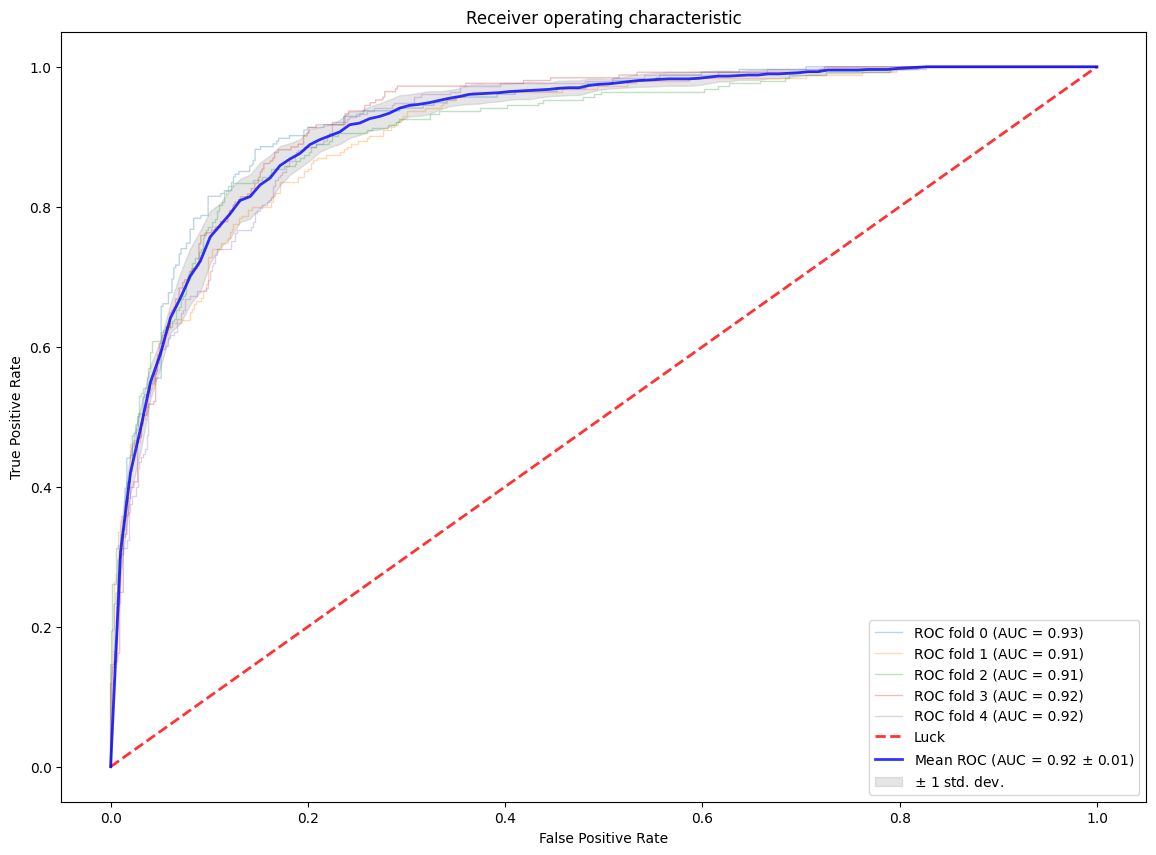

,AUC Train,AUC Test
0,0.959489,0.927255
1,0.956098,0.909600
2,0.959614,0.912921
3,0.958479,0.924973
4,0.955309,0.915515


In [58]:
cv = StratifiedKFold(n_splits=NFOLDS, random_state=1234, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])

if EXP =='RF':
    clf = RandomForestClassifier(random_state=0, min_samples_leaf = 7)#max_depth=50, , min_samples_leaf = 7
elif EXP == 'XGB':
    clf = XGBClassifier(max_depth=5, n_estimators=40, subsample=0.9, learning_rate=0.1, random_state = 142)
elif EXP == 'NN':
    clf = MLPClassifier(hidden_layer_sizes = 157, solver = 'adam', learning_rate = 'adaptive', random_state = 142)

else:
    clf = LogisticRegression(random_state = 142, n_jobs = -1)

fprs, tprs, scores, op,op_f,  od , acc , fpr_0, tpr_0, fpr_1, tpr_1 = [], [], [], [],[], [], [], [], [], [], []

start_time = datetime.now() 
for (train, test), i in zip(cv.split(data, y), range(5)):
    clf.fit(data.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)
    y_pred = clf.predict(data.iloc[test])
    o_p, o_p_fpr, o_d , acc_ , fpr_0_, tpr_0_, fpr_1_, tpr_1_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline wo/TTA'+' model:'+str(i))
    acc.append(acc_)
    op.append(o_p)
    op_f.append(o_p_fpr)
    od.append(o_d)
    fpr_0.append(fpr_0_) 
    tpr_0.append(tpr_0_)
    fpr_1.append(fpr_1_) 
    tpr_1.append(tpr_1_)
time_elapsed_baseline = datetime.now() - start_time    
plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])


## Baseline using Thresholds optimizer

In [59]:
cv = StratifiedKFold(n_splits=NFOLDS, random_state=1234, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])

if EXP =='RF':
    clf = RandomForestClassifier(random_state=0, min_samples_leaf = 7)
elif EXP == 'XGB':
    clf = XGBClassifier(max_depth=5, n_estimators=40, subsample=0.9, learning_rate=0.1, random_state = 142)
elif EXP == 'NN':
    clf = MLPClassifier(hidden_layer_sizes = 157, solver = 'adam', learning_rate = 'adaptive', random_state = 142)
else:
    clf = LogisticRegression(random_state = 142)

fprs, tprs, scores, op_tho,op_f_tho, od_tho, acc_tho, fpr_0_tho, tpr_0_tho, fpr_1_tho, tpr_1_tho = [], [], [], [],[], [], [], [], [], [], []
start_time = datetime.now()
for (train, test), i in zip(cv.split(data, y), range(5)):
    clf.fit(data.iloc[train], y.iloc[train].astype(int))
    
    y_pred_tho = []
    postprocess_est = ThresholdOptimizer(
                       estimator=clf)
                       #constraints="equalized_odds")
                       #objective="accuracy_score")
                       #predict_method='predict_proba')
    postprocess_est.fit(data.iloc[train],  y.iloc[train].astype(int), sensitive_features=data.iloc[train][PRIV_FEATURE])
    y_pred_tho = postprocess_est.predict(data.iloc[test], sensitive_features=data.iloc[test][PRIV_FEATURE])
    ("The score for this model is ", score)
    o_p_tho,o_p_tho_fpr, o_d_tho, acc_tho_, fpr_0_tho_, tpr_0_tho_, fpr_1_tho_, tpr_1_tho_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred_tho, 'subexperiment - baseline THO'+' model:'+str(i))
    op_tho.append(o_p_tho)
    op_f_tho.append(o_p_tho_fpr)
    od_tho.append(o_d_tho)
    acc_tho.append(acc_tho_)
    
    fpr_0_tho.append(fpr_0_tho_) 
    tpr_0_tho.append(tpr_0_tho_) 
    fpr_1_tho.append(fpr_1_tho_) 
    tpr_1_tho.append(tpr_1_tho_)
time_elapsed_tho = datetime.now() - start_time 



performance for whole ds:subexperiment - baseline THO model:0
conf matrix:
  [[481  65]
 [ 92 162]] 
accuracy:  0.80375 precision:  0.7136563876651982 recall:  0.6377952755905512 fpr:  0.11904761904761904 tpr:  0.6377952755905512 fn+fp 157
performance for 0 sub-group:
conf matrix:
  [[231  23]
 [ 52  99]] 
accuracy:  0.8148148148148148 precision:  0.8114754098360656 recall:  0.6556291390728477 fpr:  0.09055118110236221 tpr:  0.6556291390728477 fn+fp 75
performance for 1 sub-group:
conf matrix:
  [[250  42]
 [ 40  63]] 
accuracy:  0.7924050632911392 precision:  0.6 recall:  0.6116504854368932 fpr:  0.14383561643835616 tpr:  0.6116504854368932 fn+fp 82
bias metrics:
avarage absolute odds difference: (close to 0) 0.048631544485974246
performance for whole ds:subexperiment - baseline THO model:1
conf matrix:
  [[475  71]
 [ 79 175]] 
accuracy:  0.8125 precision:  0.7113821138211383 recall:  0.6889763779527559 fpr:  0.13003663003663005 tpr:  0.6889763779527559 fn+fp 150
performance for 0 su

## Bias mitigation using FairTTA

In [60]:
experiment = 'baseline without TTA'
print(experiment)
print('equal opportunity for tpr: ', np.mean(op), np.var(op))
print('equal opportunity for fpr: ',np.mean(op_f), np.var(op_f))
print('avarage absolute odds difference: ', np.mean(od), np.var(od))
print('accuracy: ', np.mean(acc), np.var(acc))
print('TPR-M: ', np.mean(tpr_0), np.var(tpr_0))


baseline without TTA
equal opportunity for tpr:  0.12026328149922239 0.0017764355756072817
equal opportunity for fpr:  0.04245009294626321 0.0003365099509869443
avarage absolute odds difference:  0.08135668722274278 0.00039519358552598806
accuracy:  0.84175 4.124999999999957e-06
TPR-M:  0.6206797187960413 0.004613900750280249


In [61]:
experiment = 'baseline with ThresholdOptimizer'
print(experiment)
print('equal opportunity for tpr: ',np.mean(op_tho))
print('equal opportunity for fpr: ',np.mean(op_f_tho))
print('avarage absolute odds difference: ',np.mean(od_tho))
print('accuracy: ', np.mean(acc_tho))


baseline with ThresholdOptimizer
equal opportunity for tpr:  0.046140735658189345
equal opportunity for fpr:  0.08874387638252292
avarage absolute odds difference:  0.06744230602035613
accuracy:  0.8065


# CTGAN TTA

In [62]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=5)

In [63]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(synthetic_data.values)

In [64]:
svd_data = svd.fit_transform(transformer.transform(data.values))
#svd_data = transformer.transform(data.values)

In [65]:
svd_synthdata = svd.transform(transformer.transform(synthetic_data.values))
#svd_synthdata = transformer.transform(synthetic_data.values)

In [66]:
nbrs = NearestNeighbors(n_neighbors=2,metric='cosine').fit(synthetic_data.values)
#nbrs = NearestNeighbors(n_neighbors=1,metric='cosine').fit(svd_synthdata

In [67]:
svd_synthdata_0 = svd.transform(transformer.transform(synthetic_data_0.values))
svd_synthdata_1 = svd.transform(transformer.transform(synthetic_data_1.values))

In [68]:
nbrs_0 = NearestNeighbors(n_neighbors=1,metric='cosine').fit(svd_synthdata_0)
nbrs_1 = NearestNeighbors(n_neighbors=1,metric='cosine').fit(svd_synthdata_1)

In [69]:
pd.DataFrame(data.iloc[test].iloc[i].values.reshape(1,-1),columns=data.columns)

,gender,age,nationality,sport,ind-university_grade,ind-debateclub,ind-programming_exp,ind-international_exp,ind-entrepeneur_exp,ind-languages,ind-exact_study,ind-degree,company
0,0.0,27.0,0.308756,0.353206,60.0,0.467588,0.323162,0.291976,0.461454,2.0,0.33597,0.204637,0.424


In [70]:
cv = StratifiedKFold(n_splits=NFOLDS, random_state=111, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
#clf = RandomForestClassifier(random_state=0)#max_depth=50, , min_samples_leaf = 7
fprs, tprs, scores, op_tta4, op_f_tta4, od_tta4, acc_tta4 = [], [], [], [],[], [], []

start_time = datetime.now()
for (train, test), i in zip(cv.split(data, y), range(5)):
    clf.fit(data.iloc[train], y.iloc[train])
    
    y_pred_tta = []
    for i in range(0, len(test)):
        if (i%1000) == 0:
            print(i)
        tta_ds = pd.DataFrame(data.iloc[test].iloc[i].values.reshape(1,-1),columns=data.columns)
        sample_opposite = pd.DataFrame(data.iloc[test].iloc[i].values.reshape(1,-1),columns=data.columns)
        sample_opposite[PRIV_FEATURE] = abs(1-int(sample_opposite[PRIV_FEATURE]))
        #print(tta_ds)
        #print(sample_opposite)
        
        
        if abs(clf.predict_proba(tta_ds)[:,1] - clf.predict_proba(sample_opposite)[:,1]) > 0.5:
        
        
        
            if (tta_ds[PRIV_FEATURE] == 1).bool():
                ind = nbrs_0.kneighbors(svd_synthdata_0[i].reshape(1, -1),N_AUG,return_distance=False)
                for j in range(0, N_AUG):
                    tta_ds=tta_ds.append(synthetic_data_0.iloc[ind[0][j]])
            else:
                ind = nbrs_1.kneighbors(svd_synthdata_1[i].reshape(1, -1),N_AUG,return_distance=False)
                for j in range(0,N_AUG):
                    tta_ds=tta_ds.append(synthetic_data_1.iloc[ind[0][j]])
        
            for k in range(0, N_AUG-1):
                tta_ds=tta_ds.append(pd.DataFrame(data.iloc[test].iloc[i].values.reshape(1,-1),columns=data.columns))
                
        y_pred_tta.append(round(clf.predict_proba(tta_ds)[:,1].mean()))
        #print(tta_ds)


    ("The score for this model is ", score)
    o_p_tta4, o_p_tta4_fpr, o_d_tta4, acc_tta4_,  fpr_0_tta4_, tpr_0_tta4_, fpr_1_tta4_, tpr_1_tta4_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred_tta, 'subexperiment - CTGAN TTA'+' model:'+str(i))
    op_tta4.append(o_p_tta4)
    op_f_tta4.append(o_p_tta4_fpr)
    od_tta4.append(o_d_tta4)
    acc_tta4.append(acc_tta4_)
time_elapsed_ctgan = datetime.now() - start_time 



0
performance for whole ds:subexperiment - CTGAN TTA model:799
conf matrix:
  [[512  34]
 [ 88 166]] 
accuracy:  0.8475 precision:  0.83 recall:  0.6535433070866141 fpr:  0.06227106227106227 tpr:  0.6535433070866141 fn+fp 122
performance for 0 sub-group:
conf matrix:
  [[247  12]
 [ 45  58]] 
accuracy:  0.8425414364640884 precision:  0.8285714285714286 recall:  0.5631067961165048 fpr:  0.04633204633204633 tpr:  0.5631067961165048 fn+fp 57
performance for 1 sub-group:
conf matrix:
  [[265  22]
 [ 43 108]] 
accuracy:  0.8515981735159818 precision:  0.8307692307692308 recall:  0.7152317880794702 fpr:  0.07665505226480836 tpr:  0.7152317880794702 fn+fp 65
bias metrics:
avarage absolute odds difference: (close to 0) 0.09122399894786369
0
performance for whole ds:subexperiment - CTGAN TTA model:799
conf matrix:
  [[519  27]
 [ 99 155]] 
accuracy:  0.8425 precision:  0.8516483516483516 recall:  0.610236220472441 fpr:  0.04945054945054945 tpr:  0.610236220472441 fn+fp 126
performance for 0 sub

In [71]:
experiment = 'CTGAN TTA'+str(N_AUG)
print(experiment)
print('equal opportunity for tpr: ',np.mean(op_tta4))
print('equal opportunity for fpr: ',np.mean(op_f_tta4))
print('avarage absolute odds difference: ',np.mean(od_tta4))
print('accuracy: ', np.mean(acc_tta4))


CTGAN TTA5
equal opportunity for tpr:  0.11177014518246049
equal opportunity for fpr:  0.036457012101833566
avarage absolute odds difference:  0.07411357864214703
accuracy:  0.8474999999999999


## McNemar’s Test


In [72]:
# McNemar’s Test
mcnemar = pd.DataFrame([])
mcnemar['GT'] =  y.iloc[test]
mcnemar['BL'] = y_pred
mcnemar['THO'] = y_pred_tho
mcnemar['CTGAN'] = y_pred_tta




In [73]:
def compare_cls(gt, cls1, cls2):
    if abs(gt-cls1) == 0:
        if abs(gt-cls2) == 1:
            return 1
        else:
            return 0
    else:
        
        return 0
    

In [74]:
mcnemar['THO1'] = mcnemar.apply(lambda row: compare_cls(row['GT'], row['THO'], row['CTGAN']), axis=1)
mcnemar['CTGAN1'] =  mcnemar.apply(lambda row: compare_cls(row['GT'], row['CTGAN'], row['THO']), axis=1)


In [75]:
n_01 = mcnemar['THO1'].value_counts()
n_01 = n_01[1]

In [76]:
n_10 = mcnemar['CTGAN1'].value_counts()
n_10 = n_10[1]

In [77]:
mcnemar_test = pow((abs(n_01-n_10)-1),2)/(n_01+n_10)
#mcnemar_test[1]

In [78]:
print(mcnemar_test)

137.33653846153845
